In [ ]:
# %% [markdown]
# # Feature Engineering for Airfare Prediction

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import joblib
from pathlib import Path


In [3]:
# %%
# Load processed data
data_path = Path('../data/processed/processed_data.pkl')
if not data_path.exists():
    raise FileNotFoundError(f"Processed data not found at {data_path}")
df = pd.read_pickle(data_path)

print(f"Loaded data with shape: {df.shape}")
df.head()


Loaded data with shape: (300153, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,130,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,139,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,130,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,135,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,139,1,5955


Numerical Features Summary:
            duration      days_left          price
count  300153.000000  300153.000000  300153.000000
mean      732.934870      26.004751   20889.660523
std       431.519185      13.561004   22697.767366
min        49.000000       1.000000    1105.000000
25%       409.000000      15.000000    4783.000000
50%       675.000000      26.000000    7425.000000
75%       970.000000      38.000000   42521.000000
max      2989.000000      49.000000  123071.000000


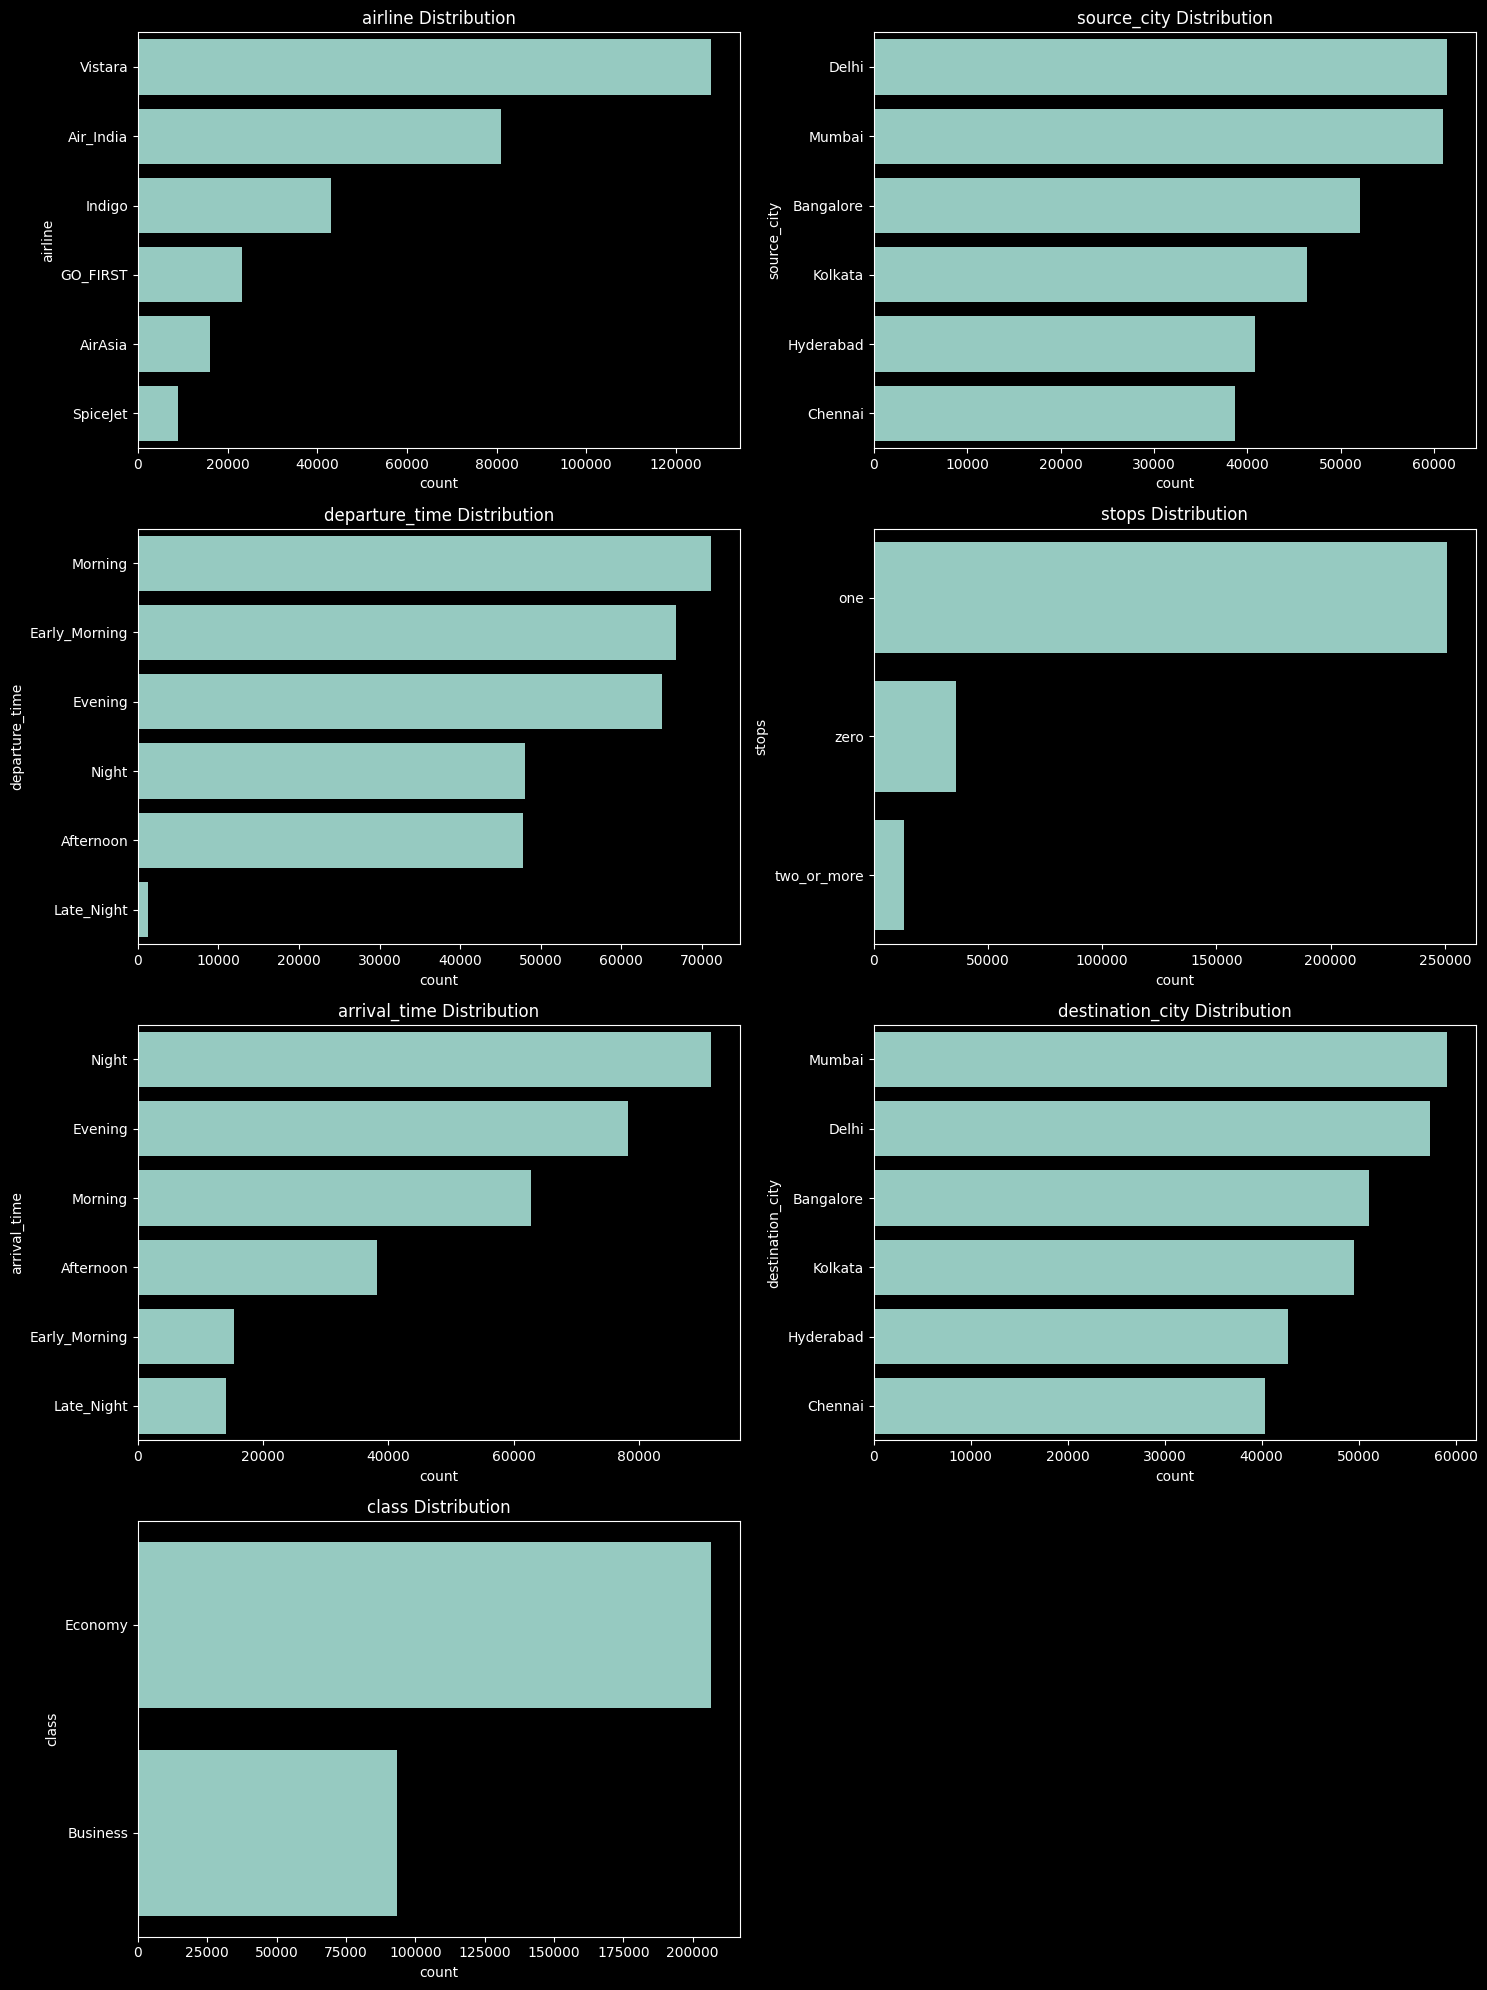

In [4]:
# %% [markdown]
# ## Feature Analysis

# %%
# Numerical features analysis
print("Numerical Features Summary:")
print(df[['duration', 'days_left', 'price']].describe())
# %%
# Categorical features analysis
cat_features = ['airline', 'source_city', 'departure_time', 
               'stops', 'arrival_time', 'destination_city', 'class']

plt.figure(figsize=(15, 20))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(4, 2, i)
    sns.countplot(y=feature, data=df, order=df[feature].value_counts().index)
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()




Preprocessor saved to ..\models\preprocessor.pkl

Total features after preprocessing: 37

First 10 feature names: ['duration' 'days_left' 'airline_AirAsia' 'airline_Air_India'
 'airline_GO_FIRST' 'airline_Indigo' 'airline_SpiceJet' 'airline_Vistara'
 'source_city_Bangalore' 'source_city_Chennai']


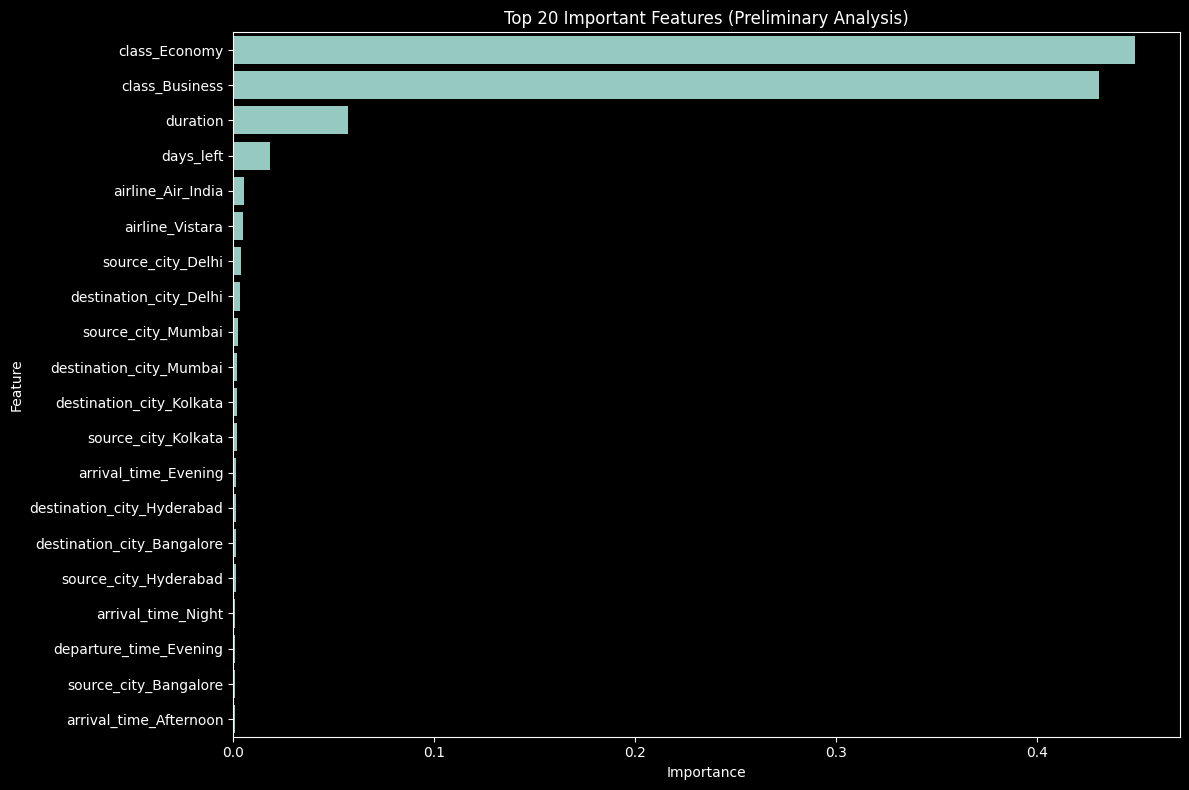

Feature importance plot saved to ..\reports\figures\preliminary_feature_importance.png
Feature names saved to ..\models\feature_names.csv


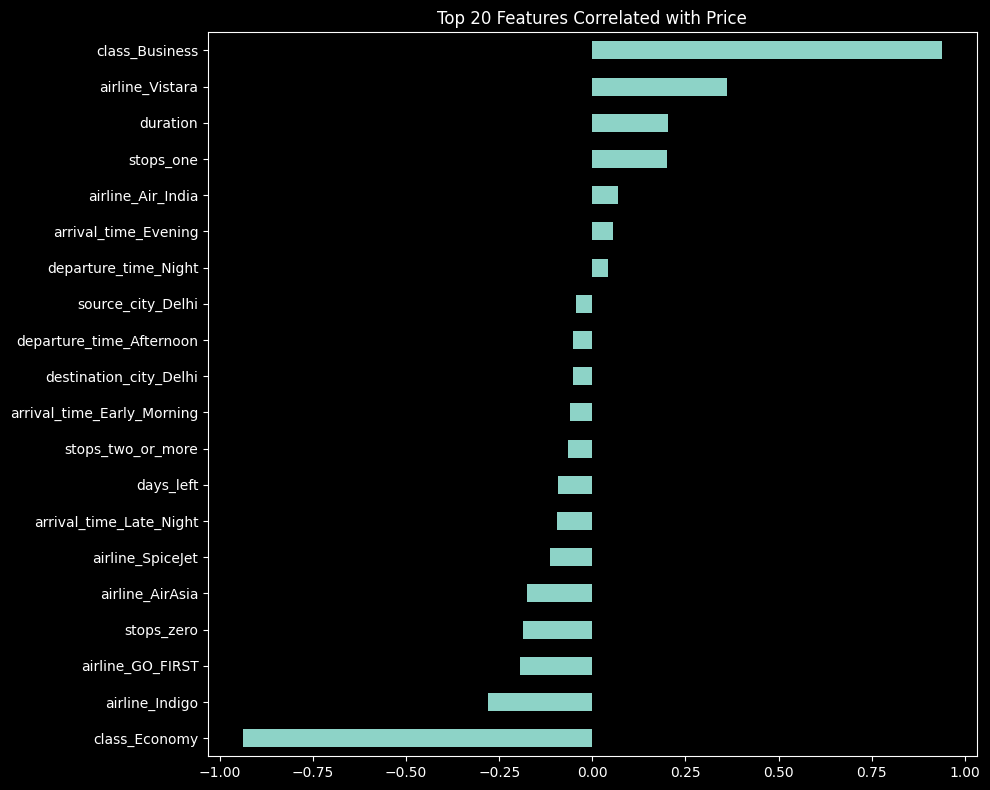

Correlation plot saved to ..\reports\figures\feature_correlations.png
Processed modeling data saved to ..\data\processed\modeling_data.pkl


In [7]:

# %% [markdown]
# ## Feature Engineering Pipeline

# %%
# Define preprocessing steps
categorical_features = ['airline', 'source_city', 'departure_time', 
                       'stops', 'arrival_time', 'destination_city', 'class']
numerical_features = ['duration', 'days_left']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# %%
# Fit and save the preprocessor
preprocessor.fit(df)
preprocessor_path = Path('../models/preprocessor.pkl')
preprocessor_path.parent.mkdir(exist_ok=True)
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to {preprocessor_path}")

# %%
# Transform the data for visualization
processed_data = preprocessor.transform(df)

# Get feature names
numeric_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_feature_names, cat_feature_names])

print(f"\nTotal features after preprocessing: {len(all_features)}")
print("\nFirst 10 feature names:", all_features[:10])

# Prepare data for modeling
X = processed_data
y = df['price'].values

# Train a quick model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# %% [markdown]
# ## Feature Importance Analysis (Preliminary)

# %%
# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features (Preliminary Analysis)')
plt.tight_layout()

# Save the plot
plot_path = Path('../reports/figures/preliminary_feature_importance.png')
plot_path.parent.mkdir(exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Feature importance plot saved to {plot_path}")

# %%
# Save feature names for later reference
feature_names_path = Path('../models/feature_names.csv')
feature_importance[['Feature']].to_csv(feature_names_path, index=False)
print(f"Feature names saved to {feature_names_path}")

# %% [markdown]
# ## Correlation Analysis

# %%
# Create a DataFrame with processed features for correlation analysis
processed_df = pd.DataFrame(processed_data, columns=all_features)
processed_df['price'] = y

# Calculate correlation with price
correlation = processed_df.corr()['price'].sort_values(key=abs, ascending=False)

# Plot top correlations
plt.figure(figsize=(10, 8))
correlation[1:21].sort_values().plot(kind='barh')
plt.title('Top 20 Features Correlated with Price')
plt.tight_layout()

# Save correlation plot
corr_plot_path = Path('../reports/figures/feature_correlations.png')
plt.savefig(corr_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Correlation plot saved to {corr_plot_path}")

# %%
# Save processed data for modeling
processed_data_path = Path('../data/processed/modeling_data.pkl')
pd.DataFrame(processed_data, columns=all_features).to_pickle(processed_data_path)
print(f"Processed modeling data saved to {processed_data_path}")
